<a href="https://colab.research.google.com/github/sdr999/sentiment-analysis-using-nlp/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [68]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [70]:
dataset=nlp.load_dataset('emotion')

In [71]:
train=dataset['train']
test=dataset['test']
val=dataset['validation']

In [72]:
def get_tweet(data):
  tweets=[x['text']for x in data]
  labels=[x['label']for x in data]
  return tweets,labels

In [73]:
tweets,labels=get_tweet(train)

In [74]:
tweets[0]

'i didnt feel humiliated'

In [75]:
labels[0]

'sadness'

## Task 4: Tokenizer

1. Tokenizing the tweets

In [76]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [77]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [78]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [79]:
lengths=[len(t.split(' '))for t in tweets]

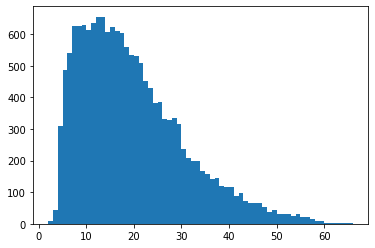

In [80]:
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [81]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [82]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [83]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [84]:
classes= set(labels)

In [85]:
print(classes)

{'fear', 'love', 'sadness', 'anger', 'surprise', 'joy'}


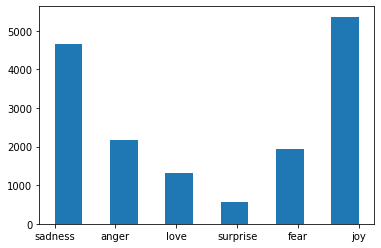

In [86]:
plt.hist(labels,bins=11)
plt.show()

In [87]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())
names_to_ids=lambda labels:np.array([class_to_index.get(x) for x in labels])

In [88]:
train_labels=names_to_ids(labels)

In [89]:
print(train_labels[0])

2


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [90]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [91]:
val_tweets,val_labels=get_tweet(val)
val_sequences=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [92]:
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_sequences,val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)]
)

Epoch 1/20
500/500 [==============================] - 12s 16ms/step - loss: 1.3097 - accuracy: 0.4641 - val_loss: 0.8234 - val_accuracy: 0.7080
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.5628 - accuracy: 0.8013 - val_loss: 0.4855 - val_accuracy: 0.8440
Epoch 3/20
500/500 [==============================] - 6s 13ms/step - loss: 0.3016 - accuracy: 0.9037 - val_loss: 0.4208 - val_accuracy: 0.8615
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2207 - accuracy: 0.9288 - val_loss: 0.4156 - val_accuracy: 0.8630
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1741 - accuracy: 0.9456 - val_loss: 0.4164 - val_accuracy: 0.8750
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1427 - accuracy: 0.9521 - val_loss: 0.4447 - val_accuracy: 0.8775
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1189 - accuracy: 0.9624 - val_loss: 0.4048 - val_accuracy: 0.8

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

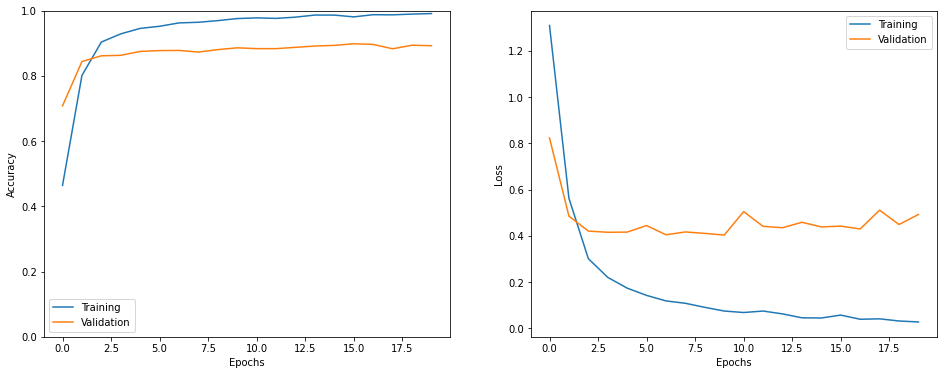

In [93]:
show_history(h)

In [94]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [95]:
_=model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4995 - accuracy: 0.8845


In [100]:
i=random.randint(0,len(test_labels)-1)
print('Sentence:',test_tweets[i])
print('Emotion:',index_to_class[test_labels[i]])
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:',pred_class)

Sentence: i didn t feel intimidated or overwhelmed with information though
Emotion: fear
1/1 [==============================] - 0s 21ms/step
Predicted Emotion: fear
